In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from datasets.cityscapes import Cityscapes
from utils import load_model, get_image_label, important_classes

In [2]:
root = os.getcwd()

# Path to your cityscapes dataset folder
data_path = os.path.join(root, 'cityscapes')

# Path your model weights folder
model_path = os.path.join(root, 'models')

In [3]:
# Name of the model to test
model_name = 'inception_frozen_0001lr.tar'

In [4]:
# Load in the model
model, optimizer, criterion, epoch, device = load_model(
                                        os.path.join(model_path, model_name))

In [5]:
input_size = (256, 512)
num_workers = 12

In [6]:
transforms = transforms.Compose([transforms.Resize(input_size),
                                              transforms.ToTensor()])

In [7]:
# List of perturbations we'll test the model on
perturbations = ['none', 'fog']

In [8]:
# Dataset and dataloader dictionaries indexed by the 
# type of perturbation it applies to images
datasets = {i: Cityscapes(data_path,
                               split='val',
                               mode='coarse',
                               target_type=['polygon'],
                               transform=transforms,
                               target_transform=get_image_label,
                               perturbation=i)
                 for i in perturbations}

In [9]:
num_testing_files = datasets['none'].__len__()
print('Testing on {} test files\n'.format(num_testing_files))

Testing on 500 test files



In [10]:
# Creating PyTorch dataloaders
dataloaders = {i: DataLoader(datasets[i], batch_size=1,
                             shuffle=True, num_workers=num_workers) 
               for i in perturbations}

In [11]:
def test_model(num_imgs, model):
    fig = plt.figure(len(perturbations) * num_imgs, (12,12))
    
    # Tests the model on a given number of images
    i = 1
    for _ in range(num_imgs):
        # Choose a random image
        idx = np.random.randint(0, num_testing_files)
        
        # Test on each perturbation
        for perturb in perturbations:
            image, label = datasets[perturb][idx]
            
            # Place image on gpu and add batch dimension
            image = image.to(device)
            image = image.unsqueeze(0)
            
            with torch.no_grad():
                outputs = model(image)

                # Get the prediction
                _, pred = torch.max(outputs, 1)
            
            image = image.squeeze().cpu().numpy().transpose(1,2,0)
            
            ax = plt.subplot(num_imgs, len(perturbations), i)
            ax.set_title('Perturbation: {}   Label: {}   Pred: {}'.format(
                                        perturb, 
                                        important_classes[label],
                                        important_classes[pred]))
            ax.axis('off')
            ax.imshow(image)
            i += 1

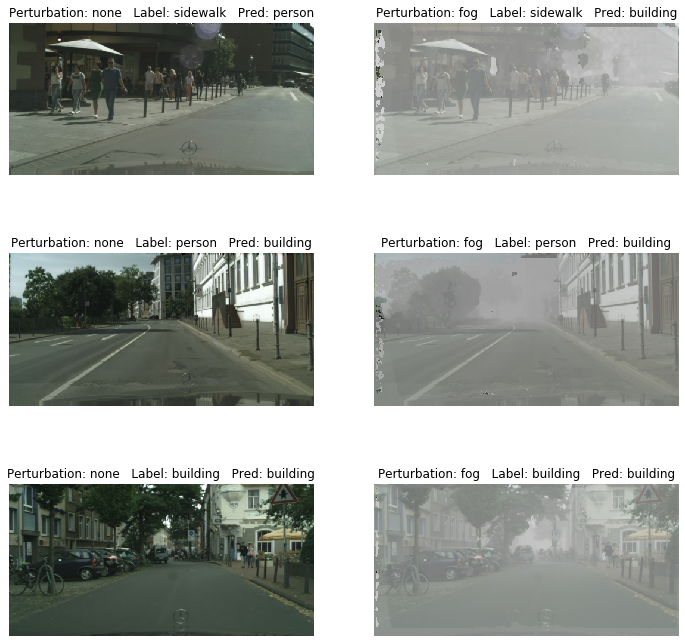

In [13]:
test_model(3, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


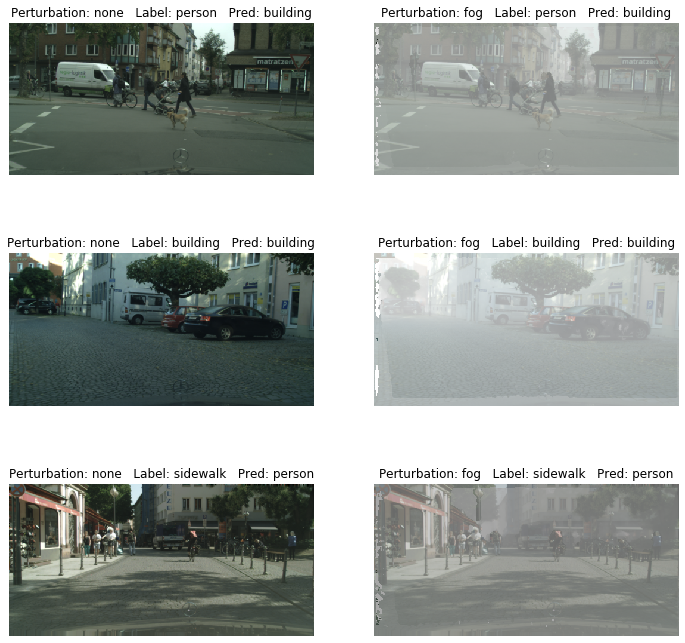

In [14]:
test_model(3, model)